<a href="https://colab.research.google.com/github/fbeilstein/machine_learning/blob/master/lecture_12_gaussian_mixture_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Gaussian mixture model (GMM)

In this lecture we will address **G**aussian **M**ixture **M**odel incrementally and will try to understand
* what is mixture model and why is it appropriate for clustering;
* what is Gaussian (we will need multinomial Gaussians in particular);
* how we can fit mixture model using **E**xpectation **M**aximization technique;
* how we can cluster data by fitting Gaussian mixture model (using EM);
* explore GMM.

OK, let's explore these points one by one.

#Mixture models and clustering

Suppose we have discrete random variable $Z$:

$$
Z \sim \text{Discrete}(\pi_1,\, \dots \, ,\pi_K), \qquad \text{Support}[Z]={1,\, \dots \, ,K}.
$$

Suppose now you have a family of $K$ probability distributions:

$$
\mathcal{P}_k,\qquad k=1\dots K.
$$

We define a following two-steps probability model (mixture model):

---

* `Let random variable` Z `generate` a number $z=1 \dots K$. `Let` $z=k$;
* `Let random variable` $\mathcal{P}_k$` generate a random number that we proclaim an outcome of mixture model.`

---

We can say that

$$
\text{Mixture}=\sum_{k} \pi_k \cdot \mathcal{P}_k.
$$

This notation makes sense as

$$
\text{pdf}_{{Mixture}}=\sum_{k} \pi_k \cdot \text{pdf}_{\mathcal{P}_k}.
$$

Note, that $z$ is a discrete (categorical) random variable with support $1, \dots, K$ acting like a **tag** conditioning probability distribution we use to  generate specific point on the second step. The role of $z$ is close of that of the cluster label.
 After the point is generated the tag is erased, making it impossible to know what probability distribution was responsible for this point. 

<br>

![](https://raw.githubusercontent.com/fbeilstein/machine_learning/master/lecture_12/tags.png) 

<br>

This is like mixing two liquids: after the mixing is finished there is no way way to know which molecule originated from which liquid.

Now let $\mathcal{P}_k$ can be the same distributions but taken with different
parameters $\theta_k$. Also usually we do many trials of mixture model.

Now we have two-staged process

* Pick $z_i$ distributed as $\text{Discrete}(\pi_1,\dots ,\pi_K)$. Let $z_i=k$.
* Now pick $x_i$ distributed as $ p(x_i|\theta_k)$.

![](https://raw.githubusercontent.com/fbeilstein/machine_learning/master/lecture_12/bag.png) 

$p(x_i|\theta_k)=p(x_i|z_i=k)$ is the conditional probability to get $x_i$ if we generate tag $k$ in the first step.

The marginal distribution averaged over all possible results obtained at the first step reads as:

$$
p(x_i) = \sum_{k=1}^K p(z_i=k)\,  p(x_i|z_i=k)=\sum_{k=1}^K p(z_i=k)\,  p(x_i|\theta_k).
$$

We can reverse the problem and ask what is the probability that the given point had tag $k$. This is called probability membership or responsibility and could be found using Bayes theorem.

$$
a_{ik}=p(z_i=k | x_i)=\frac{p(z_i=k)\, p(x_i | z_i=k)}{\sum_{k=1}^K p(z_i=k)\, p(x_i | z_i=k)}=\frac{\pi_k \, p(x_i | \theta_k)}{\sum_{k=1}^K \pi_k \, p(x_i | \theta_k)}
$$

So 

$$
\boxed{\text{If we knew } \{\theta, \pi\} \text{ we can calculate } a_{ik} \text{ via Bayes theorem}}.
$$

<br>

![](https://raw.githubusercontent.com/fbeilstein/machine_learning/master/lecture_12/mm.png)


In what follow we are going to mix Gaussians so let me remind you about this distribution.

# Gaussian

## Univariate Gaussian

Suppose

$$
X \sim \mathcal{N}(\mu, \sigma),
$$

then

$$
p_{\mathcal{N}}(x;\mu, \sigma)=\frac{1}{\sqrt{2 \pi \sigma^2 }}e^{-\frac{(x-\mu)^2}{2 \sigma^2}}.
$$

We know that

$$
\begin{aligned}
& \mu=\mathbb{E}[X],\\
& \sigma^2=\mathbb{V}ar[X]=\mathbb{C}ov[X,X].
\end{aligned}
$$

In [0]:
#@title #1D Gaussian

import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
import scipy.stats

# Properties for plots
plt.style.use([{
    "figure.figsize":(12,9), # Figure size
    "xtick.labelsize": "large", # Font size of the X-ticks
    "ytick.labelsize": "large", # Font size of the Y-ticks
    "legend.fontsize": "x-large", # Font size of the legend
    "axes.labelsize": "x-large", # Font size of labels
    "axes.titlesize": "xx-large", # Font size of title
    "axes.spines.top": False,
    "axes.spines.right": False,
},'seaborn-poster'])

# Plots pdf of a normal distribution
@widgets.interact(mu=(-25.0,25.0), var=(0.3,30.0))
def plot_pdf(mu, var):
    '''
    Takes mean, variance, range of x and y axes, and whether CDF desired.
    Plots PDF, and optionally CDF.
    '''
    x = np.linspace(-50, 50, 1001)
    sig = var**0.5
    P_norm = scipy.stats.norm.pdf(x, mu, sig)
    
    plt.plot(x, P_norm, 'b', linewidth=3.0, label = "PDF")
    y0 = (1/(sig*np.sqrt(2*np.pi)))*np.exp(-0.5)
    ym = 1/(sig*np.sqrt(2*np.pi))
    plt.plot([mu-sig, mu-sig], [0, y0], 'm--',linewidth = 2.0)
    plt.plot([mu+sig, mu+sig], [0, y0], 'm--', linewidth = 2.0, label = '$\mu\pm\sigma$')
    plt.plot([mu,mu], [0,ym], 'g--', linewidth = 2.0, label = r'$\mu$')
    
    plt.title('PDF of N({},{})'.format(mu,var))
    plt.xlabel('x')
    plt.ylabel('p(x;  $\mu$, $\sigma$)')
    plt.legend()
    plt.show()

interactive(children=(FloatSlider(value=0.0, description='mu', max=25.0, min=-25.0), FloatSlider(value=15.15, …

## Multivariate Gaussian

Suppose

$$
\boldsymbol{X} \sim \mathcal{N}(\boldsymbol{\mu}, \Sigma),
$$

where $\boldsymbol{x},\boldsymbol{\mu} \in \mathbb{R}^n$ and $\Sigma \in \mathbb{R}^n \times \mathbb{R}^n$. 

Then

$$
\require{action}
p_{\mathcal{N}}(\boldsymbol{x};\boldsymbol{\mu}, \Sigma)=\frac{1}{\sqrt{(2 \pi)^n |\Sigma| }}e^{-\frac{1}{2}(\boldsymbol{x}-\boldsymbol{\mu})^{\top}\Sigma^{-1}(\boldsymbol{x}-\boldsymbol{\mu})}=\frac{1}{\sqrt{|2 \pi \Sigma| }}e^{-\frac{1}{2}(\boldsymbol{x}-\boldsymbol{\mu})^{\top} \toggle{\Sigma^{-1}}{Q}\endtoggle (\boldsymbol{x}-\boldsymbol{\mu})},
$$

where $|\Sigma|=\det{\Sigma}$, $\boldsymbol{\mu}$ - is a mean vector, $\Sigma$ - is a covariance matrix.

The inverse of the covariance matrix is called the precision matrix, denoted by $Q=\Sigma^{-1}$.

The meaning of $\boldsymbol{\mu}$ and $\Sigma$ is the following

$$
\begin{aligned}
& \boldsymbol{\mu}=\mathbb{E}[\boldsymbol{X}], \\
& \Sigma_{ij}=\mathbb{C}ov[X_i,X_j]=\mathbb{E}[(X_i-\mu_i)(X_j-\mu_j)].
\end{aligned}
$$



#Gaussian mixture

## Univariate Gaussians

Suppose

$$
X \sim \sum_i \pi_i \, \mathcal{N}(\{\mu_i\}, \{\pi_i\}),
$$

$$
p_{\mathcal{N}}\left(x;\{\sigma_i\}, \{\mu_i \}, \{{\pi}_i\}\right)=\sum_i \pi_i \frac{1}{\sqrt{2 \pi \sigma_i^2 }}e^{-\frac{(x-\mu_i)^2}{2\sigma_i^2}},
$$
$$
\sum_i \pi_i=1, \\
0 \leq \pi_i \leq 1.
$$

#Example of Gaussian mixture (height distribution)

In a population the height of men and women is distributed approximately normal but with different mean (men are generally taller then women) and stds.
The resulting height distribution in a population (irrespective of sex) is thus a mixture of two Gaussians. The tags, we have talked before essentially say "**man**" and  "**woman**" in this setup.
If we erase the tags and look at the resulting height probability distribution it will be the sum of two slighly different Gaussians multiplied by $\approx0.5$ (as there's approximately as many men as women) and added together. It will look like a flattened out Gaussian.

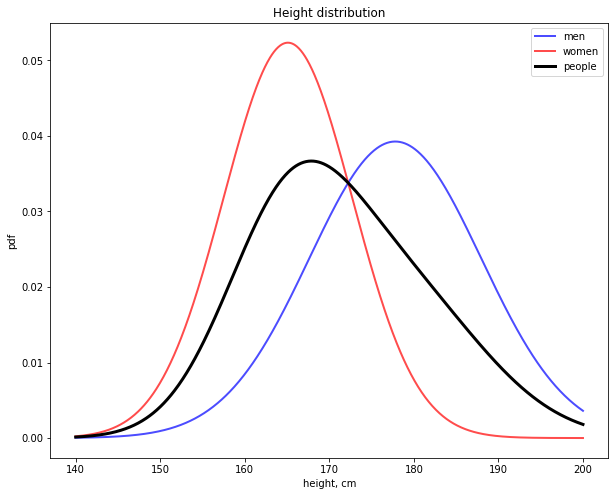

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

x = np.linspace(140, 200, 1001)
sig1 = 10.16
mu1 = 177.8
sig2 = 7.62
mu2 = 165.1
P_norm1 = scipy.stats.norm.pdf(x, mu1, sig1)
P_norm2 = scipy.stats.norm.pdf(x, mu2, sig2)
P_norm3 = 0.5 * (P_norm1 + P_norm2)

fig = plt.figure(figsize=(10, 8))
plt.plot(x, P_norm1, 'b', linewidth=2.0, label = "men", alpha=0.7)
plt.plot(x, P_norm2, 'r', linewidth=2.0, label = "women", alpha=0.7)
plt.plot(x, P_norm3, 'k', linewidth=3.0, label = "people")

plt.title('Height distribution')
plt.xlabel('height, cm')
plt.ylabel('pdf')
plt.legend()
plt.show()

#Example of Gaussian mixture (image segmentation based on prevalent colour)

Here is an example of Gaussian Mixture in image segmentation with histogram that is a mixture of Gaussians.

![](https://raw.githubusercontent.com/fbeilstein/machine_learning/master/lecture_12/seg.gif) 

[Source](https://en.wikipedia.org/wiki/Mixture_model#/media/File:Movie.gif)


##Multivariate Gaussians

Suppose

$$
X \sim \sum_i \pi_i \, \mathcal{N}(\{\boldsymbol{\mu}_i\}, \{\sigma_i\}),
$$

then

$$
p_{\mathcal{N}}(\boldsymbol{x}; \{\Sigma_i \}, \{\boldsymbol{\mu}_i \}, \{\pi_i \})=\sum_i \pi_i \frac{1}{\sqrt{(2 \pi)^n |\Sigma_i| }}e^{-\frac{1}{2}(\boldsymbol{x}-\boldsymbol{\mu}_i)^{\top}\Sigma_i^{-1}(\boldsymbol{x}-\boldsymbol{\mu}_i)},
$$

$$
\sum_i \pi_i=1, \\
0 \leq \pi_i \leq 1.
$$

$Note:$ I won't use boldface notation in the future calculations (for the sake of readibility)

$$
\boldsymbol{X} \rightsquigarrow X, \\
\boldsymbol{x} \rightsquigarrow x, \\
\boldsymbol{\mu} \rightsquigarrow \mu.
$$


##Hidden(latent) parameter formulation

In statistics, latent variables (from Latin: present participle of lateo (“*lie hidden*”), as opposed to observable variables) are variables that are not directly observed but are rather inferred (through a mathematical model) from other variables that are observed (directly measured). Mathematical models that aim to explain observed variables in terms of latent variables are called latent variable models.

#Interactive 1D Gaussian mixture

In [0]:
#@title MM of 3 Gaussians
from ipywidgets import HBox, VBox, FloatSlider, FloatRangeSlider
import ipywidgets as widgets
import scipy.stats

words = ['mu_1', 'sigma_1', 'mu_2', 'sigma_2', 'mu_3', 'sigma_3']
mins  = [0.0, 1.0, 0.0, 1.0, 0.0, 1.0]
maxes = [100.0, 10.0, 100.0, 10.0, 100.0, 10.0]
vals  = [10.0, 10.0, 50.0, 10.0, 90.0, 10.0]
sliders = [FloatSlider(description=w, min=n, max=x, value=v) for w,x,n,v in zip(words, maxes, mins, vals)]
pi_slider = FloatRangeSlider(value=[0.3, 0.6], min=0.0, max=1.0, description='pi(1,2,3)')
boxes = [VBox([pi_slider])]
for slider1, slider2 in zip(sliders[::2], sliders[1::2]):
  boxes.append(VBox([slider1, slider2]))

def plot_pdf(pi, mu1, sig1, mu2, sig2, mu3, sig3):
  pi1, pi2 = pi; pi2 -= pi1; pi3 = 1.0 - pi2 - pi1;
  x = np.linspace(0, 100, 1001)
  fig = plt.figure(figsize=(10, 8))
  P_sum = np.zeros(x.shape)
  for mu, sig, c, pi, i in [[mu1, sig1, 'r', pi1, 1], [mu2, sig2, 'g', pi2, 2], [mu3, sig3, 'b', pi3, 3]]:
    P = scipy.stats.norm.pdf(x, mu, sig)
    P_sum += P * pi
    plt.plot(x, P, c, linewidth=2.0, label="{}".format(i), alpha=np.clip(pi, 0.0, 1.0))

  
  plt.plot(x, P_sum, 'k', linewidth=3.0)

  plt.title('Mixture of 3 gaussians')
  plt.xlabel('x')
  plt.ylabel('y')
  plt.legend()
  plt.show()

out = widgets.interactive_output(plot_pdf, {
    "pi": pi_slider,
    "mu1": sliders[0], "sig1": sliders[1],
    "mu2": sliders[2], "sig2": sliders[3],
    "mu3": sliders[4], "sig3": sliders[5]})

display(HBox(boxes), out)

Output()

# GMM via MLE



We aim to estimete all the parameters of the GMM

$$
\theta=\{\color{red}{\pi_k}, \color{red}{\mu_k}, \color{red}{\Sigma_k} \}.
$$

Let's use MLE to do that. Likelihood function given data reads as

$$
p(X|\theta)=\prod_{i=1}^N \sum_{k=1}^K \pi_k \, p_{\mathcal{N}}(x_i | \mu_k, \Sigma_k).
$$

Log-Likelihood reads as

$$
\begin{aligned}
\log p(X|\theta)&=\sum_{i=1}^N \log \left( \sum_{k=1}^K \pi_k \, p_{\mathcal{N}}(x_i | \mu_k, \Sigma_k)\right) ,\\
\theta_{ML}&=\text{argmax}_\theta \log p(X|\theta).
\end{aligned}
$$

Summation $\sum_{k=1}^K$ inside the logarithm: makes ML estimate difficult, no closed form solution. We make simplification: **assume we know the responsibilities** (which we actually not). As we shall see  

$$
\boxed{\text{If we knew } a_{ik} \text{ we can calculate }  \{\theta\}}.
$$

![](https://raw.githubusercontent.com/fbeilstein/machine_learning/master/lecture_12/uro.png) 

This the situation we encountered before in $k$-means


$\color{red}{\boxed{\mu_k}}$

First we differentiate $L$ with respect to $\mu_k$
$$
\frac{\partial L}{\partial \mu_k}=\sum_{i=1}^N \underbrace{\frac{\pi_k \, p_{\mathcal{N}}(\mu_k, \Sigma_k)}{\sum_{j=1}^K \pi_j \, p_{\mathcal{N}}(\mu_j, \Sigma_j)}}_{\color{grey}{a_{ik}} \color{grey}{(\text{assume that we know them})}}\Sigma^{-1}(x_i-\mu_k)=\sum_{i=1}^N a_{ik}\Sigma^{-1}(x_i-\mu_k).
$$

Set $\frac{\partial L}{\partial \mu_k}=0$ and solve for $\mu_k$.

$$
\mu_k=\frac{\sum_{i=1}^N a_{ik}x_i}{\sum_{i=1}^N a_{ik}}.
$$

**Weighted mean** of all data points, weight: responsibility (posterior probability of latent variable)

$\color{red}{\boxed{\Sigma_k}}$

Differentiating  w.r.t $\Sigma_k$ we get

$$
\Sigma_k=\frac{\sum_{i=1}^N a_{ik}(x_i-\mu_k)(x_i-\mu_k)^{\top}}{\sum_{i=1}^N a_{ik}}.
$$

$\color{red}{\boxed{\pi_k}}$

$\pi_k$'s have constaint $\sum\pi_k=1$ so we should use Lagrange multiplier $\lambda$

$$
L'=\log{p(X|\theta)}+\lambda \left(\sum_{k=1}^K \pi_k-1\right).
$$

$$
\frac{\partial L'}{\partial \pi_k}=\sum_{i=1}^N\frac{p_{\mathcal{N}}(x_i|\mu_k,\Sigma_k)}{\sum_{j=1}^K \pi_j \, p_\mathcal{N}(x_i|\mu_j,\Sigma_j)}+\lambda.
$$

Setting $\frac{\partial L'}{\partial \pi_k}=0$, we get $\lambda = -N$ and

$$
\pi_k=\frac{\sum_{i=1}^N a_{ik}}{N}.
$$

To sum up we got

$$
\begin{aligned}
\color{red}{\mu_k}&=\frac{\sum_{i=1}^N a_{ik}x_i}{\sum_{i=1}^N a_{ik}}, \\
\color{red}{\Sigma_k}&=\frac{\sum_{i=1}^N a_{ik}(x_i-\mu_k)(x_i-\mu_k)^{\top}}{\sum_{i=1}^N a_{ik}}, \\
\color{red}{\pi_k} &=\frac{\sum_{i=1}^N a_{ik}}{N}, \\
a_{ik}&=p(z_n=k|x_n)=\frac{\pi_k \, p(x_n|\theta_k)}{\sum_{j=1}^K \pi_j \, p(x_n|\theta_j)}.
\end{aligned}
$$

If we put this to an algorithm we get

<br>


---

**GMM algorithm**

---

`1. Initialize ` $\theta=\{\pi_k, \mu_k, \Sigma_k\}$.

`2. Compute log-likelihood ` $L=\log{p(X|\theta)}=\sum_{i=1}^N \log{\sum_{k=1}^K} \pi_k \, \mathcal{N}({x_i}|\mu_k, \Sigma_k)$.

`3. Repeat until convergence: `

$\qquad$ `Set responsibility: ` 

$$
a_{ik}=\frac{\pi_k \, p(x_n|\theta_k)}{\sum_{j=1}^K \pi_j \, p(x_n|\theta_j)}.
$$

$\qquad$ `Update parameters: `

$$
\begin{aligned}
& \mu_k=\frac{\sum_{i=1}^N a_{ik}x_i}{\sum_{i=1}^N a_{ik}} ,\\
& \Sigma_k=\frac{\sum_{i=1}^N a_{ik}(x_i-\mu_k)(x_i-\mu_k)^{\top}}{\sum_{i=1}^N a_{ik}} ,\\
& \pi_k=\frac{\sum_{i=1}^N a_{ik}}{N}.
\end{aligned}
$$

$\qquad$ `Recompute log-likelihood L.`

---

<br>

#Expectation maximization theory

Suppose you aim to minimize likelihood function
$$
l(\theta; X)=p(X;\theta),
$$

then you can do it iteratively:

$$
\boxed{\theta^{(m)}=\text{argmax}_\theta \mathbb{E}_{Z|X,\theta^{(m-1)}}\log{p(X,Z| \theta)}}.
$$

Actually the iteration step could be decomposed into two 

$$
\begin{aligned}
& \text{Expectation step (E step):} && \mathcal{Q}(\theta; \theta^{(m)})=\mathbb{E}_{Z|X,\theta^{(m)}}[\log{L(\theta; X)}], \\
& \text{Maximization step (M step):} && \theta^{(m+1)}=\text{argmax}_{\theta}\, \mathcal{Q}(\theta; \theta^{(m)}).
\end{aligned}
$$

Let me elaborate on the E-step:

$$
 \mathcal{Q}(\theta; \theta^{(m)})=\mathbb{E}_{Z|X,\theta^{(m)}}[\log{L(\theta; X)}]=\sum_{i} p(Z_i|X,\theta^{(m)}) \cdot \log{L(\theta; X)}.
 $$

 We can use Bayes rule to calculate $p(Z_i|X,\theta^{(t)})$

 $$
 p(Z_i|X,\theta^{(m)})=\frac{\quad \, \, \, p(X,\theta^{(m)}|Z_i)\cdot p(Z_i)}{\sum_{j} p(X,\theta^{(m)}|Z_j)\cdot p(Z_j)}.
 $$

 Other methods exist to find maximum likelihood estimates, such as gradient descent, conjugate gradient, or variants of the Gauss–Newton algorithm. Unlike EM, such methods typically require the evaluation of first and/or second derivatives of the likelihood function.

Let's have a look how one can come up with the solution

* $\text{argmax}_\theta \, \log{p(X|\theta)}\quad \quad \qquad \qquad \qquad \text{We want to find this}$
* $\text{argmax}_\theta \, \log{\sum_Z p(X|\theta)} \qquad \qquad \qquad \text{summation inside log}$
* $\text{argmax}_\theta \, \mathbb{E}_{Z|X,\theta} \log p(X,Z|\theta) \qquad \qquad \text{we don't know } p(Z|X,\theta)$
* $\text{argmax}_\theta \, \mathbb{E}_{Z|X,\theta^{(m-1)}} \log p(X,Z|\theta)
\qquad \, \, \text{guess and iterate: works!}$


Algorithmically this looks like this

<br>


---

**E-M algorithm**

---


`1. Initialize ` $\theta^{(0)}=\{\pi_k, \mu_k, \Sigma_k\}$

`2. Compute log-likelihood ` $L^{(0)}=\log{p(X|\theta^{(0)})}$

`3. For ` $m=1,\dots, T$

$\qquad$ `Posterior distribution of ` $Z: p(Z|X,\theta^{(m-1)})$ 

$\qquad$ `Expected Complete Likelihood under this distribution of ` $Z$:

$$
\begin{aligned}
\mathcal{Q}(\theta, \theta^{(m-1)})&=\sum_{Z} \,\underbrace{p(Z|X,\theta^{(m-1)})}_{\substack{\color{grey}{\text{distribution of }Z} \\ \color{grey}{\text{assuming }\theta^{(m-1)}}}} \cdot \underbrace{\log{p(X,Z|\theta)}}_{\substack{\color{grey}{\text{complete data likelihood}}\\ \color{grey}{\text{given unknown }\theta}}}=\, \mathbb{E}_{Z|X,\theta^{(m-1)}} \log{p(X,Z|\theta)}
\end{aligned}
$$

$\qquad$ `Calculate` $\qquad$ $\theta^{(m)}=\text{argmax}_{\theta} \,  \mathcal{Q}(\theta, \theta^{(m-1)})$

$\qquad$ `Check for convergence: stop if ` $L^{(m)}-L^{(m-1)}<\epsilon$

---

<br>



# Illustration for GMM

![](https://raw.githubusercontent.com/fbeilstein/machine_learning/master/lecture_12/gmm_a.png)  

# GMM via EM (GEM = GMM)

$\boxed{\text{E-step}}$

Let's plug in Gaussian distributions into $\mathcal{Q}$ function

$$
\begin{aligned}
\mathcal{Q}(\theta, \theta^{(m-1)})&=\mathbb{E}_{Z|X, \theta^{(m-1)}} \log {p(X,Z|\theta)}=\\
& = \mathbb{E}_{Z|X, \theta^{(m-1)}} \left[\sum_{i=1}^N \log{p(x_i, z_i|\theta)}\right]= \\
&= \sum_{i=1}^N \mathbb{E}_{Z|X, \theta^{(m-1)}} \left[ \log{\prod_{k=1}^K (\pi_k p(x_i|\theta_k))^{\mathbb{I}{(x_i=k)}}} \right]= \\
& = \sum_{i=1}^N \sum_{k=1}^K \mathbb{E}_{Z|X, \theta^{(m-1)}} [\mathbb{I}(z_n=k)]\log{(\pi_k p(x_i|\theta_k))} = \\
& = \sum_{i=1}^N \sum_{k=1}^K p(z_n=k | X, \theta^{(m-1)}) \log{(\pi_k p(x_i|\theta_k))}=\\
& = \sum_{i=1}^N \sum_{k=1}^K a_{{ik}_{|\theta^{(m-1)}}} \log{(\pi_k p(x_i|\theta_k))}= \\
& = \sum_{i=1}^N \sum_{k=1}^K a_{{ik}_{|\theta^{(m-1)}}} \log{\pi_k}+a_{{ik}_{|\theta^{(m-1)}}} \log{p(x_i|\theta_k)}.
\end{aligned}
$$

$\boxed{\text{M-step}}$


$\color{red}{\boxed{\mu_k}}$

$$
\begin{aligned}
\frac{\partial \mathcal{Q}}{\partial \mu_k}&=\frac{\partial}{\partial \mu_k} \sum_{i=1}^N \sum_{k=1}^K a_{{ik}_{|\theta^{(m-1)}}} \log{\pi_k}+a_{{ik}_{|\theta^{(m-1)}}} \log{p(x_i|\theta_k)} = \\
& = \frac{\partial}{\partial \mu_k} \sum_{i=1}^N \sum_{k=1}^K a_{{ik}_{|\theta^{(m-1)}}} \log{p(x_i|\theta_k)}=\\
& = \frac{\partial}{\partial \mu_k} \sum_{i=1}^N \sum_{k=1}^K a_{{ik}_{|\theta^{(m-1)}}} \log\left[ \frac{1}{(2\pi)^{n/2}|\Sigma_k|^{1/2}} e^{-\frac{1}{2}(x_i-\mu_k)^{\top}\Sigma_k^{-1}(x_i-\mu_k)}\right].
\end{aligned}
$$


Use $\frac{\partial}{\partial \mu_k}(x_i-\mu_k)^{\top}\Sigma_k^{-1}(x_i-\mu_k)=-2 \Sigma_k^{-1}(x_i-\mu_k)$ and equate derivative to zero to get

$$
\color{red}{\mu_k}=\frac{a_{{ik}_{|\theta^{(m-1)}}} x_i}{\sum_{i=1}^N a_{{ik}_{|\theta^{(m-1)}}}}.
$$


$\color{red}{\boxed{\Sigma_k}}$

$$
\begin{aligned}
\frac{\partial \mathcal{Q}}{\partial \Sigma_k}&=\frac{\partial}{\partial \Sigma_k} \sum_{i=1}^N \sum_{k=1}^K a_{{ik}_{|\theta^{(m-1)}}} \log{\pi_k}+a_{{ik}_{|\theta^{(m-1)}}} \log{p(x_i|\theta_k)}=\\
&=\frac{\partial}{\partial \Sigma_k} \sum_{i=1}^N \sum_{k=1}^K a_{{ik}_{|\theta^{(m-1)}}} \log{\left[\frac{1}{(2\pi)^{n/2}|\Sigma_k|^{1/2}} e^{-\frac{1}{2}(x_i-\mu_k)^{\top}\Sigma_k^{-1}(x_i-\mu_k)}\right]}=\\
&=\frac{\partial}{\partial \Sigma_k} \sum_{i=1}^N \sum_{k=1}^K a_{{ik}_{|\theta^{(m-1)}}} \left[\log{\frac{1}{(2\pi)^{n/2}}}-\frac{1}{2} \log{|\Sigma_k|}-\frac{1}{2}(x_i-\mu_k)^{\top}\Sigma^{-1}(x_i-\mu_k)\right].
\end{aligned}
$$

If we use $\frac{\partial |A|}{\partial A}= |A|(A^{\top})^{-1}$ and $\frac{\partial x^{\top}Ay}{\partial A}=-(A^{\top})^{-1}xy^{\top}(X^{\top})^{-1}$,
set $\frac{\partial \mathcal{Q}}{\partial \Sigma_k}=0$ and solve we get 

$$
\color{red}{\Sigma_k}=\frac{\sum_{i=1}^N a_{{ik}_{|\theta^{(m-1)}}}(x_i-\mu_k)(x_i-\mu_k)^{\top}}{\sum_{i=1}^N a_{{ik}_{|\theta^{(m-1)}}}}, \\
$$

$\color{red}{\boxed{\pi_k}}$

$$
\frac{\partial \mathcal{Q}}{\partial \pi_k}=\frac{\partial}{\partial \pi_k} \sum_{i=1}^N \sum_{k=1}^K a_{{ik}_{|\theta^{(m-1)}}} \log{\pi_k}+a_{{ik}_{|\theta^{(m-1)}}} \log{p(x_i|\theta_k)}.
$$

As $\sum_k \pi_k=1$ we need to introduce Lagrange multipliers

$$
J=\sum_{i=1}^N \sum_{k=1}^K a_{{ik}_{|\theta^{(m-1)}}} \log{\pi_k}+\lambda\left(\sum_k \pi_k-1\right).
$$

Let $n_k=\sum_{i=1}^N a_{{ik}_{|\theta^{(m-1)}}}$

$$
\sum_{k=1}^K n_k=\sum_{k=1}^K \sum_{i=1}^N a_{{ik}_{|\theta^{(m-1)}}}= \sum_{i=1}^N \underbrace{\sum_{k=1}^K p(z_i=k|X,\theta^{(m-1)})}_{=1}=N.
$$

$$
\frac{\partial J}{\partial \pi_k}=\frac{\partial}{\partial \pi_k}\left(\sum_{k=1}^Kn_k\log{\pi_k}+\lambda\left(\sum_k \pi_k-1\right)\right)=\frac{n_k}{\pi_k}+\lambda=0 \Longrightarrow \lambda \pi_k=-n_k.
$$

$$
\lambda \left(\sum_k \pi_k\right)=-\sum_k n_k \Longrightarrow \lambda=-N \text{ and } \pi_k=\frac{n_k}{N}.
$$

So

$$
\color{red}{\pi_k}=\frac{\sum_{i=1}^N a_{{ik}_{|\theta^{(m-1)}}}}{N}.
$$

These formulas are the same we obtained with MLE (with a simplification we had to adopt).

# $K$-means via EM

$
\def\id{{\Large\unicode{x1D7D9}}}
\boxed{\text{E-step}}
$

Assume a GMM where covariance of each component $\epsilon \cdot \id$, fized constant $\epsilon$ and $\pi_k=1/K$.

We have only one set of parameters to estimate: 

$$
\theta=\{\color{red}{\mu_k}\}.
$$

$$
\begin{aligned}
p(x| \theta_k)&=\frac{1}{\sqrt{(2 \pi)^n |\Sigma_k| }}e^{-\frac{1}{2}(x-\boldsymbol{\mu}_k)^{\top}\Sigma_k^{-1}(x-\boldsymbol{\mu})_k}=\frac{1}{(2 \pi \epsilon)^{n/2}}e^{-\frac{1}{2\epsilon}\| x- \mu_k\|^2}, \\
a_{ik}&=\frac{\pi_k \, p(x_i|\theta_k)}{\sum_{j=1}^K \pi_j \, p(x_i|\theta_j)}=\frac{\pi_k e^{-\frac{\|x_i-\mu_k\|^2}{2\epsilon}}}{\sum_{j=1}^K \pi_j \, e^{-\frac{\|x_i-\mu_j\|^2}{{2\epsilon}}}}.
\end{aligned}
$$

As $\epsilon \to 0$ term for which $\|x_i-\mu_j\|^2$ is smallest will go to $0$ most slowly $\Longrightarrow a_{ij} \to 1$ and $a_{ik} \to 0$ for $k \neq j$

$$
\begin{aligned}
a_{ij}&=\left\{
 \begin{align}
   &1 \quad  \text{ if } \quad j=\text{argmin}_j \| x_i-\mu_k\|^2 \\
   &0 \quad \text{otherwise}
 \end{align}
\right. ,\\
\mathcal{Q}&=\sum_{i=1}^N \sum_{k=1}^N a_{ik} \log {\pi_k}+a_{ik} \log {p(x_i|\theta_k)}.
\end{aligned}
$$

$\boxed{\text{M-step}}$

$\color{red}{\boxed{\mu_k}}$

$$
\begin{aligned}
\frac{\partial \mathcal{Q}}{\partial \mu_k} &=
\frac{\partial}{\partial \mu_k} \sum_{i=1}^N a_{ik} \log {\frac{1}{(2 \pi \epsilon)^{n/2}}e^{-\frac{1}{2\epsilon}\| x- \mu_k\|^2}},\\
\frac{\partial \mathcal{Q}}{\partial \mu_k} &=0. \qquad \Longrightarrow \qquad \color{red}{\mu_k} =\frac{\sum_{i=1}^N a_{ik} x_i}{\sum_{i=1}^N a_{ik}}.
\end{aligned}
$$

<br>

---

**Lloyd's k-means algorithm**

---


`1. Initialize `$K$ `cluster centers` $\mu_k^{(0)}$

`2. For ` $m=1,\dots T$

*  `Assign `$x_n$ `to the closest cluster with cluster center `$\mu_k$
$\qquad$
*  `Re-estimate cluster centers: ` $\mu_k^{(m)}$ `as the mean of all data points assigned to cluster `$k$
$\qquad$
* `Check for convergence`

---

<br>


#Motivating GMM: Weaknesses of k-Means

Let's me remind you the caveats of $k$-means.
Let's generate some spherical blobs of data.

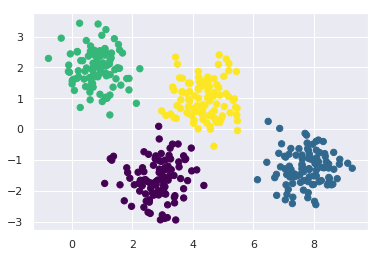

In [0]:
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4, cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

# Plot the data with K Means Labels
from sklearn.cluster import KMeans
kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

Mote that we are more certain about some points being part of a cluster than others (and we can't estimate that with k-means).

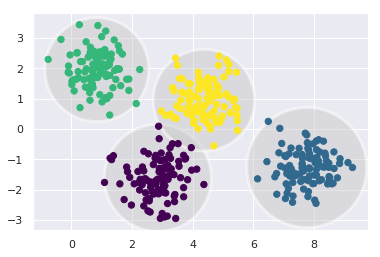

In [0]:
# hard-sphere-cutoff workaround
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max() for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

This doesn't work so well for elongated blobs.

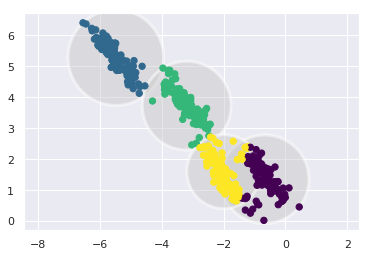

In [0]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

Here's where GMM comes to the rescue.

#Generalizing E–M: Gaussian Mixture Models

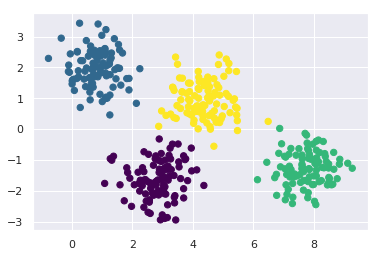

In [0]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

$a_{ik}$ (probability memberships/responsibilities) measure our level of uncertainty.

In [0]:
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.    0.    0.463 0.537]
 [1.    0.    0.    0.   ]
 [1.    0.    0.    0.   ]
 [0.    0.    0.    1.   ]
 [1.    0.    0.    0.   ]]


We can depict $a_{ik}$ with the size of the points at the scatter plot: just take the maximum value, square it (emphasizes differences) and let it be the radius of the point. Note how point close to the borderline are smaller.

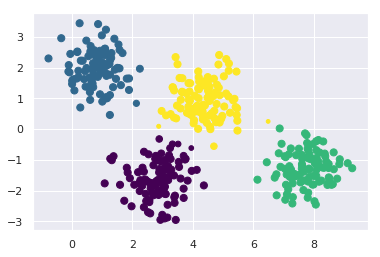

In [0]:
size = 50 * probs.max(1) ** 2  
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size);

As we saw GMM is very similar to k-means but more general and versatile.
We saw that it also uses an expectation–maximization.
   
   * Choose starting guesses for the location and shape
   * Repeat until converged:
      *  E-step: for each point, find weights encoding the probability of membership in each cluster
      *  M-step: for each cluster, update its location, normalization, and shape based on all data points, making use of the weights

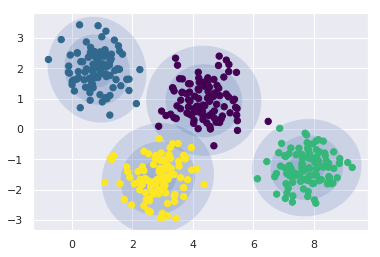

In [0]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)
        
gmm = GaussianMixture(n_components=4, random_state=42)
plot_gmm(gmm, X)

Take a look at the stretched blobs. We can specify the type of covariance to hint `GaussianMixture` on the shape of the blobs.

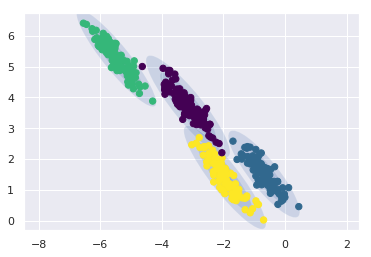

In [0]:
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, X_stretched)

##Choosing the covariance type

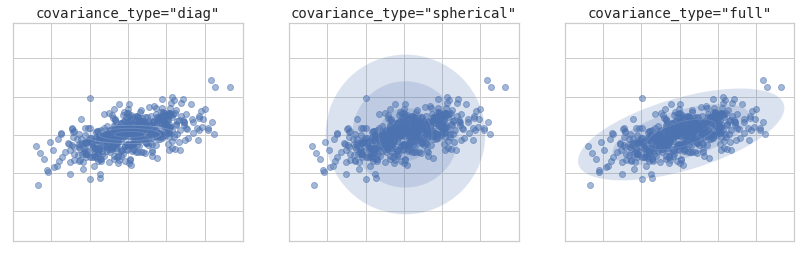

In [0]:
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse
import seaborn as sns

sns.set_style("whitegrid")

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
      U, s, Vt = np.linalg.svd(covariance)
      angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
      width, height = 2 * np.sqrt(s)
    elif covariance.shape == (2,):
      angle = 0
      width, height = covariance
    else:
      angle = 0
      width, height = 2 * np.sqrt(covariance[0,0]), 2 * np.sqrt(covariance[0,0])
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))

fig, ax = plt.subplots(1, 3, figsize=(14, 4), sharex=True)
#fig.subplots_adjust(wspace=0.05)

rng = np.random.RandomState(5)
X = np.dot(rng.randn(500, 2), rng.randn(2, 2))

for i, cov_type in enumerate(['diag', 'spherical', 'full']):
    model = GaussianMixture(1, covariance_type=cov_type).fit(X)
    ax[i].axis('equal')
    ax[i].scatter(X[:, 0], X[:, 1], alpha=0.5)
    ax[i].set_xlim(-3, 3)
    ax[i].set_title('covariance_type="{0}"'.format(cov_type), size=14, family='monospace')
    if cov_type == 'spherical':
      cov = np.array([model.covariances_])
    else:
      cov = model.covariances_[0]
    draw_ellipse(model.means_[0], cov, ax[i], alpha=0.2)
    ax[i].xaxis.set_major_formatter(plt.NullFormatter())
    ax[i].yaxis.set_major_formatter(plt.NullFormatter())

#GMM as Density Estimation

Actually, GMM is a **generative probabilistic model** describing the distribution of the data. Consider previous example with two moons.

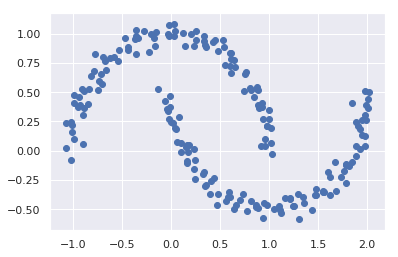

In [0]:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);

GMM with $2$ Gaussians does not perform well with this set.

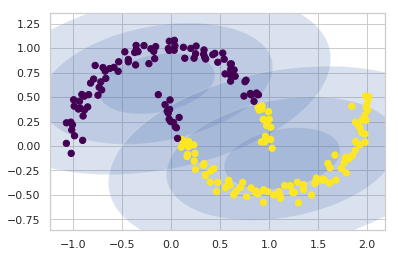

In [0]:
gmm2 = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
plot_gmm(gmm2, Xmoon)

We can do much better if we use more ($16$) Gaussians.

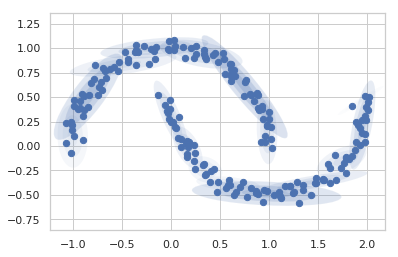

In [0]:
gmm16 = GaussianMixture(n_components=16, covariance_type='full', random_state=0)
plot_gmm(gmm16, Xmoon, label=False)

Actually we can use GMM to generate (thus generative model) random points distributed with the same law as the given dataset. That's a cool feature.

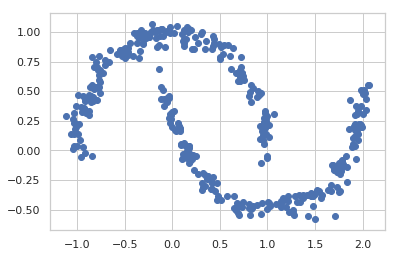

In [0]:
Xnew, _ = gmm16.sample(400)  # if Ynew isn't valuable
plt.scatter(Xnew[:, 0], Xnew[:, 1])

##How many components?

How can we choose the number of Gaussians in GMM?

   * cross-validation
   * The Akaike information criterion [(AIC)](https://en.wikipedia.org/wiki/Akaike_information_criterion)

   AIC is an estimator of out-of-sample prediction error and thereby relative quality of statistical models for a given set of data. Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models. Thus, AIC provides a means for model selection.

   Suppose that we have a statistical model of some data. Let k be the number of estimated parameters in the model. Let $\hat{L}$ be the maximum value of the likelihood function for the model. Then the AIC value of the model is the following.

   $$
   \text{AIC}=2k-2 \ln{\hat{L}}.
   $$

   * The Bayesian information criterion [(BIC)](https://en.wikipedia.org/wiki/Bayesian_information_criterion)

$$
   \text{BIC}=\ln{(N)}k-2 \ln{\hat{L}},
$$

where $N$ is the number of data points (sample size), $k$ - number of parameters estimated by the model, $\hat{L}$ - the maximized value of the likelihood function of the model $M$, $\hat{L}=p(X|\hat{\theta},M)$.


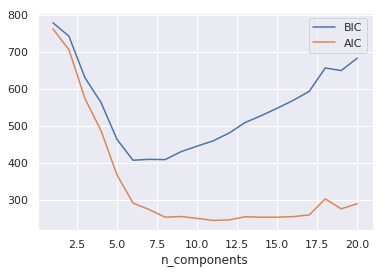

In [0]:
from sklearn.mixture import GaussianMixture

n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(Xmoon) for n in n_components]
plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

   * number of components measures how well GMM works as a density estimator, **not** how well it works as a clustering algorithm.
   * you better use GMM as density estimator, not clusterizer

#Example: GMM for Generating New Data

We can use generative power of GMM to obtain new handwritten digits from the standard digits corpus.

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

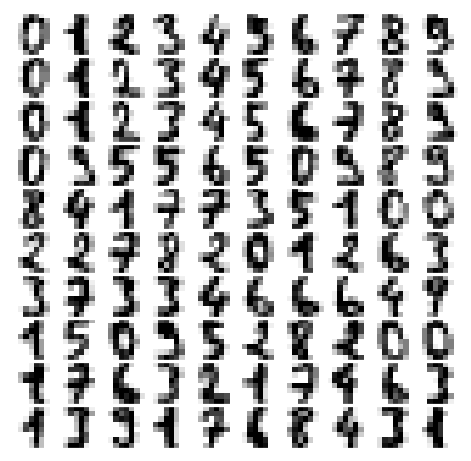

In [0]:
def plot_digits(data):
  fig, ax = plt.subplots(10, 10, figsize=(8, 8),
  subplot_kw=dict(xticks=[], yticks=[]))
  fig.subplots_adjust(hspace=0.05, wspace=0.05)
  for i, axi in enumerate(ax.flat):
    im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
  im.set_clim(0, 16)
  
plot_digits(digits.data)

We have too many dimensions ($64$), let's reduce them with PCA. 

In [0]:
from sklearn.decomposition import PCA

pca = PCA(0.99, whiten=True)
data = pca.fit_transform(digits.data)
data.shape

(1797, 41)

We use AIC to choose number of Gaussians.

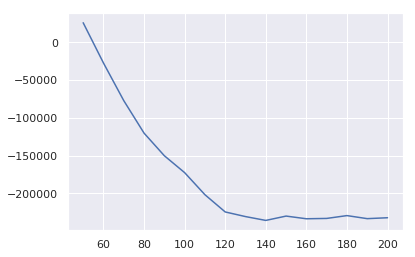

In [0]:
n_components = np.arange(50, 210, 10)
models = [GaussianMixture(n, covariance_type='full', random_state=0) for n in n_components]
aics = [model.fit(data).aic(data) for model in models]
plt.plot(n_components, aics);


Let's fit GMM and check for convergence.

In [0]:
gmm = GaussianMixture(110, covariance_type='full', random_state=0)
gmm.fit(data)
print(gmm.converged_)

True


In [0]:
data_new, _ = gmm.sample(100)
data_new.shape

(100, 41)

Now use inverse transform (PCA) to generate digits.

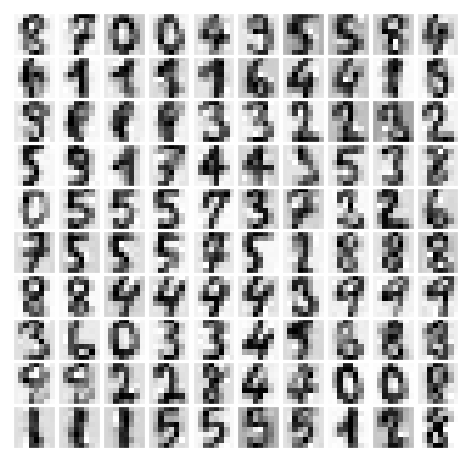

In [0]:
digits_new = pca.inverse_transform(data_new)
plot_digits(digits_new)

#Interactive GMM

In [0]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

def cluster(X, n):
  gmm2 = GaussianMixture(n_components=n, covariance_type='full', random_state=0)
  gmm2.fit(X)
  y_kmeans = gmm2.predict(X)
  centers = gmm2.means_
  covs = gmm2.covariances_
  w = gmm2.weights_
  return y_kmeans, centers, covs, w

In [0]:
#@title Interactive GMM
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Ellipse
from matplotlib import cm

def draw_ellipse(position, covariance, ax, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))
        
def plot_clusters(X, y, center, covariances, weights):
  fig = plt.figure(figsize=(10,10))
  ax = fig.gca()
  ax.tick_params(axis="y",direction="in", pad=-40)
  ax.tick_params(axis="x",direction="in", pad=-15)
  ax.set_xticks(np.arange(-.75, 1, .25))
  ax.set_yticks(np.arange(-.75, 1, .25))
  ax.set_xlim([-1, 1])
  ax.set_ylim([-1, 1])

  cmap = cm.get_cmap('viridis')
  c_norm = len(center)
  plt.scatter(X[:, 0], X[:, 1], c=y/c_norm, s=50)
  plt.scatter(center[:, 0], center[:, 1], c='red', marker='x', s=200, alpha=0.5);
  
  w_factor = 0.2 / weights.max()
  for pos, covar, w, c in zip(center, covariances, weights, range(c_norm)):
    clr = 0.5 if c_norm <= 1 else c/(c_norm-1)
    draw_ellipse(pos, covar, ax, alpha=w * w_factor, fc=cmap(clr))

  plt.close(fig)

  return fig

import base64
import io

def figure_to_base64(fig):
  buf = io.BytesIO()
  fig.savefig(buf, format='png', bbox_inches='tight', pad_inches=0);
  image_base64 = base64.b64encode(buf.getvalue()).decode('utf-8').replace('\n', '')
  buf.close()
  return image_base64


def get_surface_data(centers, covs, w):
  x_ = np.linspace(-1.0, +1.0, num=300)
  y_ = np.linspace(-1.0, +1.0, num=300)
  xx, yy = np.meshgrid(x_, y_)
  x_vec = np.transpose(np.vstack([xx.ravel(), yy.ravel()])) - centers[:, np.newaxis]
  prod_1 = np.array([np.dot(v,m) for v,m in zip(x_vec, np.linalg.inv(covs))])
  prod_2 = np.array([np.sum(v1*v2, axis=1) for v1,v2 in zip(prod_1, x_vec)])
  g = np.exp(-0.5 * prod_2) / np.sqrt(np.linalg.det(covs).shape) / 2.0 / np.pi
  g = g.reshape((g.shape[0], x_.shape[0], y_.shape[0]))
  G = np.sum(g*w[:,np.newaxis, np.newaxis], axis=0)
  C = np.argmax(g, axis=0)
  return x_, y_, G, C

import json
from IPython.display import display, clear_output

def invoke(pts, n):
  global html_div

  data = np.array(pts).reshape((-1, 2))
  X = data / 300.0 - 1.0
  X[:, 1] *= -1.0

  y_kmeans, centers, covs, w = cluster(X, int(n))
  figr = plot_clusters(X, y_kmeans, centers, covs, w)
  image_base64 = figure_to_base64(figr)

  x_, y_, G, C = get_surface_data(centers, covs, w)

  return IPython.display.JSON({'image': image_base64, 
                               'g_x': x_.tolist(), 'g_y': y_.tolist(), 'g_z': G.tolist(), 'g_c': C.tolist(),
                               's_x': X[:, 0].tolist(), 's_y': X[:, 1].tolist(), 's_z': [0]*len(X), 's_c': y_kmeans.tolist()})


import IPython
from google.colab import output

main_str = '''
  <script src="https://cdn.plot.ly/plotly-latest.min.js"></script> 
  <script type="application/javascript">
  
    var active_pt = null;
    var all_pts = [];
    var classAbtn = [650, 100];
    var classBbtn = [650, 200];
    var ptR = 10.0;
    var params = null;
    var debug_txt = "";
    var bg_image = new Image();

    function is_close(pt1, pt2) {
      return   (pt1[0] - pt2[0])*(pt1[0] - pt2[0])
            +  (pt1[1] - pt2[1])*(pt1[1] - pt2[1])
            <= ptR*ptR;
    }
  
    function circ(ctx, pos) {
      ctx.beginPath();
      ctx.arc(pos[0], pos[1], ptR, 0.0, 2.0 * Math.PI, 0);
      ctx.fillStyle = 'rgba(50, 50, 50, 0.2)';
      ctx.fill();
    }
    
    
    function draw() {
      var canvas = document.getElementById('canvas');
      if (canvas.getContext) {
        var ctx = canvas.getContext('2d');
        
        ctx.clearRect(0, 0, canvas.width, canvas.height); // cleanup before start
        ctx.drawImage(bg_image, 0, 0, 600, 600);
        ctx.strokeRect(0, 0, 600, 600); // field
        
        ctx.font = '20px serif';
        ctx.fillStyle = 'black';
        ctx.fillText(debug_txt, 200, 200);
        
        if (active_pt) {
          circ(ctx, [active_pt[0], active_pt[1]]);
        }
        all_pts.forEach(function (item, index) {
          circ(ctx, [item[0], item[1]]);
        });

      }
    }
    
    var timer

    function get_state() {
      var rates = document.getElementsByName('rate');
      for(var i = 0; i < rates.length; i++)
        if(rates[i].checked)
          return rates[i].value;
      return "none";
    }

    
    function mdown_handle(evt) {
      evt.stopPropagation();
      x = evt.offsetX;
      y = evt.offsetY;
      state = get_state();
      if (state == "add") {
        if (x < 600)
            all_pts.push([x, y]);
        return;
      }

      idx = -1;
      all_pts.forEach(function (item, index) {
        if (is_close([x,y], [item[0], item[1]])) {
          idx = index;
        }
      });
      if (idx <= -1)
          return;
      if (state == "move") {
        active_pt = all_pts[idx];
        all_pts.splice(idx, 1);
      }
      if (state == "del")
          all_pts.splice(idx, 1);
    }
    
    function mmove_handle(evt) {
      evt.stopPropagation();
      if (get_state() != "move")
          return;
      x = evt.offsetX;
      y = evt.offsetY;
      if (active_pt) {
        active_pt[0] = x;
        active_pt[1] = y;
      }
    }
    
    function mup_handle(evt) {
      evt.stopPropagation();
      x = evt.offsetX;
      y = evt.offsetY;
      if (x >= 600) {
        active_pt = null;
      }
      if (active_pt) {
        all_pts.push(active_pt);
        active_pt = null;
      }
    }
    
    function clear_field() {
      active_pt = null;
      all_pts = [];
    }


   function plot_3d(g_x, g_y, g_z, g_c)
   {
     cell_for_plot = document.getElementById('for_plotly_plot');
     //Plotly.deleteTraces(cell_for_plot, [0, 1]);
     var data = [{
           x: g_x,
           y: g_y,
           z: g_z,
           type: 'surface',
           surfacecolor: g_c,
           opacity: 0.9,
           showscale: false,
           colorscale: "Viridis"
        }];
  
     var layout = {
          title: '3D Gaussian profile',
          autosize: false,
          width: 600,
          height: 600,
          showlegend: false,
          scene: {
            camera: {
              up: {x: 0, y: 1, z: 0},
              center: {x: 0, y: 0, z: 0},
              eye: {x: 0.0, y: -1.0, z: 1.4}
            }
          }
        };
     Plotly.newPlot(cell_for_plot, data, layout);
   }

   function plot_scatter(s_x, s_y, s_z, s_c)
   {
          
     cell_for_plot = document.getElementById('for_plotly_plot');
     var data = [{
           x: s_x,
           y: s_y,
           z: s_z,
           type: 'scatter3d',
           mode: 'markers',
           marker: {
             size: 4,
             colorscale: "Viridis",
             color: s_c,
             line: {
               width: 2,
               color: 'rgba(0, 0, 0, 0.5)'
             }
           }
        }];
    Plotly.plot(cell_for_plot, data, {});
   }


    var cur_depth = 1;

    async function calculate() {
      if (!all_pts)
        return;
      var merged = [].concat.apply([], all_pts);
      const result = await google.colab.kernel.invokeFunction('notebook.InvSVM', [merged, cur_depth], {});
      params = result.data['application/json'];
            
      bg_image.src = 'data:image/  png;base64,' + params.image;
      cell_for_plot = document.getElementById('for_plotly_plot');
      
      plot_3d(params.g_x, params.g_y, params.g_z, params.g_c);
      plot_scatter(params.s_x, params.s_y, params.s_z, params.s_c);
      
    }

   function h_change(x) {
    el = document.getElementById("slider_val");
    cur_depth = x;
    el.innerHTML = x;
  }

 </script>

<div id="everything" style="height:600px;">
<div id="for_plotly_plot" style="position:absolute; top:0px; left:0px; height:600px; width:600px;">
</div>
<div id="custom_controls" style="position:absolute; top:0px; left:600px;">
  <canvas id="canvas" width="800" height="600" 
    onmousedown="mdown_handle(event)"
    onmousemove="mmove_handle(event)"
    onmouseup="mup_handle(event)"></canvas>
  <div style="position:absolute; top:275px; left:625px;">
   <div style="border-style: solid;">
    <input type="radio" id="r1" name="rate" value="add" checked="checked"> Add Feature
    <br>
    <input type="radio" id="r2" name="rate" value="move"> Move Features
    <br>
    <input type="radio" id="r3" name="rate" value="del"> Delete Feature
    <br>
    <button type="button" onclick="clear_field();">
      Clear
    </button>
   </div>
   <br><br>Number of clusters:<br>
    <input type="range" min="1" max="9" value="1" oninput="h_change(this.value)">
    <br><div id="slider_val">1</div>
   <br><br>
    <button type="button" onclick="calculate();">
      GMM
    </button>
  </div>
</div>
<div>
  
<script>
function init()
{
  timer = setInterval(draw, 10);
}

init();
</script>
'''

display(IPython.display.HTML(main_str))
output.register_callback('notebook.InvSVM', invoke)